# K-Means Clustering

This implementation is done without the use of any external libraries. We will only use the builtin random library for generating random numbers and the builtin typing library for type hints in our function definitions. This is meant for education and demonstration purposes as it is less efficient than other established libraries that are based on compiled and parallelized languages like C.

The K-means model will find k clusters from unlabeled data.

**Main Algorithm Overview:**

1. Initialize the cluster centroids

2. repeat next steps until convergence:
    - for each point $x^i$ find the closest centroid and assign it to that cluster
    - for each cluster centroid find the mean of all points assigned then update that centroid to the new mean.
    - measure the total movement of all centroids and if less than the threshold exit the loop

This main algorithm will be repeated using different cluster centroid seeds. After each run we calculate the sum of square distances between each point and their assigned cluster center. Then the resulting centroids with the smallest sum of those distances will be chosen as the centroids to use. This is done because the result of a single k-means run is highly dependent on the cluster initialization. For example a poor initialization could result in orphaned centroids or multiple clusters belonging to a single centroid.

In [66]:
import random
from typing import List, Self, Any, Tuple

## Helper functions
We need a way to generate a random number between two end points. We will do this with a function to generate a random sample of 1 from within the given bounds.

In [67]:
def random_sample(low:int|float, high:int|float) -> float:
    """generate a random sample between low and high

    Args:
        low (int | float): the lower bound of the sample
        high (int | float): the upper bound of the sample

    Returns:
        float: a random number between low and high
    """
    rand_num = low + (high - low) * random.random()
    return rand_num

## Distance function
To calculate the movement of the centroids during training and the distance between points and centroids we need a distance metric. Here we will use the euclidean distance. 

It is defined as:

$$dist(x, y)=\sqrt{\sum_{i=1}^{n}{(x^i - y^i)^2}}$$

In [68]:
def calc_euclidean_dist(point_1:List[float], point_2:List[float]) -> float:
    """calculate the euclidean distance between two n-dimensional points

    Args:
        point_1 (List[float]): n-dimensional coordinates of point_1
        point_2 (List[float]): n-dimensional coordinates of point_2

    Returns:
        float: the euclidean distance between point_1 and point_2

    Notes:
        dist=\\sqrt{\\sum{(x^i - y^i)^2}}
    """

    dist = sum([(point_1[i] - point_2[i])**2 for i in range(len(point_1))]) ** .5

    return dist

## Functions directly used by the kMeans Model
### Now we are going to define four functions that are directly used by the kmeans model.

First we need to be able to initialize the models centroids. This will be done using random initialization. This random Initialization will use the minimum and maximum of each column and generate a random number between them. There are other ways to initialize the centroids and some methods are better than others. For example in scikit-learn implements a "k-means++" initialization which is "based on an empirical probability distribution of the points’ contribution to the overall inertia"(sklearn-documentation). The simple random initialization we use here is much simpler but can sometimes get stuck if it ends up exactly between clusters.

In [69]:
def initialize_centroids_rand_dist(data:List[List[int|float]], k:int) -> List[List[float]]:
    """Initialize cluster centroids this should be 
        done randomly within the range of all points

    Args:
        data (List[List[float]]): The data to initialize the clusters over
        k (int): The number of clusters

    Returns:
        List[List[float]]: Initialized cluster centers

    Steps:
        1. initialize min's and max's list with the length m of an nxm matrix i.e the columns
        2. go through each row in the dataset ensuring that each entry is within the range 
        of the min and max of the dataset
        3. for each cluster k initialize a random sample of between the min and max for each column
        4. return the centroid coordinates. this will be a kxn matrix where each row is a centroid 
            and each column if the i'th coordinate for that cluster
    Notes:
        We don't assume the points in data are randomly shuffled. If we make this assumption 
        then we can use the points in data to initialize directly. However if wrong then it would 
        introduce bias for high density spacial data.
    """
    mins = [float('inf') for _ in range(len(data[0]))]
    maxs = [float('-inf') for _ in range(len(data[0]))]

    for row in data:
        mins = [min(row[i], mins[i]) for i in range(len(row))]
        maxs = [max(row[i], maxs[i]) for i in range(len(row))]

    centroids = []
    for i in range(k):
        centroids.append([random_sample(mins[i], maxs[i]) for i in range(len(mins))])

    return centroids

def initialize_centroids_random_per_feature(data:List[List[int|float]], k:int) -> List[List[float]]:
    """This initialization chooses a random selection from each feature for every centroid
        The result could end up with the same number in a feature being selected twice and 
        is thus not ideal.  

    Args:
        data (List[List[int | float]]): The data to initialize the clusters over
        k (int): The number of clusters

    Returns:
        List[List[float]]: Initialized cluster centers

    Steps:
        1. Iterate through the number of clusters
        2. Iterate through the number of features and randomly generate an index
           and append the selected value to the centroid
        3. Append the centroid to the list of centroids
    """

    number_of_data_points = len(data)

    centroids = []
    for i in range(k):
        centroid = []
        for feature in range(len(data[0])):
            index_val = int(random_sample(0, number_of_data_points))
            feature_val = data[index_val][feature]
            centroid.append(feature_val)
        centroids.append(centroid)
    return centroids

def initialize_centroids_random_data_point(data:List[List[int|float]], k:int) -> List[List[float]]:
    """This initialization, randomly chooses points from the data to use as cluster centers.
        This is done without replacement to avoid duplicate points being selected. This implementation 
        is not ideal for data that is highly spatially dense as if it is then there is a higher 
        chance that the selected centroids are members of the same cluster.

    Args:
        data (List[List[int | float]]): The data to initialize the clusters over
        k (int): The number of clusters

    Returns:
        List[List[float]]: Initialized cluster centers

    Steps:
        1. Iterate through the number of clusters and select a randomly chosen point.
           If that point is already in the list of centroids then repeat.
        2. Then return the list of centroids
    """

    number_of_data_points = len(data)

    centroids = []
    for i in range(k):
        indexes = []
        while True:
            row_index = int(random_sample(0, number_of_data_points))
            if row_index not in indexes:
                centroids.append(data[row_index])
                indexes.append(row_index)
                break

    return centroids
            


Second we will define a function to get the labels assigned to each data point based on how far away they are from each centroid. This will also be used in the predict method once training is complete.

In [70]:
def get_labels(data:List[List[int|float]], centroids:List[List[float]]) -> List[int]:
    """gets the labels of each point in the data. each label is the cluster assigned to that point

    Args:
        data (List[List[float]]): the data being fit
        centroids (List[List[float]]): the centroid coordinates

    Returns:
        list: a list of cluster labels for each data point/row in the data

    Steps: 
        1. For each data point in the dataset we iterate through the centroids and 
        calculate the closest one. 
        2. the index of that centroid gets assigned as the label for that data point
    """
    labels = []

    for row in data:
        min_dist = float('inf')
        label = None

        for i, centroid in enumerate(centroids):
            dist = calc_euclidean_dist(row, centroid)

            if min_dist > dist:
                min_dist = dist
                label = i

        labels.append(label)

    return labels

Third we will define a function to update the centroids based on the mean of the data points assigned to it.

In [71]:
def update_centroids(data:List[List[int|float]], labels:List[int], k:int) -> List[List[float]]:
    """updates the centroids by calculating new centroids based on the 
        mean of the data points assigned to the current centroids

    Args:
        data (List[List[float]]): the current data being fit and nxm matrix
        labels (List[int]): the assigned labels based on the current clusters a list of length n
        k (int): the number of clusters

    Returns:
        List[List[float]]: the list of updated centroids of size kxm
    
    Steps:
        1. Initialize a matrix with all zeros with the size kxm and a label counts array of len k
        2. Iterate through the data and labels sum the data matrix across the n axis per cluster assignment
        3. divide by the count per cluster to get the mean or new centroid for each cluster, if the cluster 
           is orphaned i.e. has no assigned data points then it does not change (to avoid the divide by zero error).
    """
    
    new_centroids = [[0 for _ in range(len(data[0]))] for _ in range(k)]
    label_counts = [0 for _ in range(k)]

    for point, label in zip(data, labels):
        curr_centroid_sum = new_centroids[label]
        new_centroids[label] = [curr_centroid_sum[i] + point[i] for i in range(len(point))]
        label_counts[label] += 1

    for i, row in enumerate(new_centroids):
        new_centroids[i] = [x / label_counts[i] if label_counts[i] != 0 else x for x in row]

    return new_centroids

Finally we define a function to determine convergence. This will calculate the sum total of the distance moved by all centroids, if this is below the threshold then we return True and stop training.

In [72]:
def should_stop(old_centroids:List[List[float]], centroids:List[List[float]], threshold:float) -> bool:
    """Determines if the movement from the updates centroids are below a given threshold.
        if so we can say that the centroids have converged and we can stop training.

    Args:
        old_centroids (List[List[float]]): The old centroids before the update
        centroids (List[List[float]]): The new centroids after the update
        tolerance (float): The tolerance threshold for centroid movement

    Returns:
        bool: Return True if the movement is below the threshold and False if it is not.

    Notes:
        This implementation uses the euclidean distance to calculate movement
    
    Steps:
        1. For each pair of centroids new vs old. calculate the sum total movement of all centroids.
        2. If the total movement of all centroids is less than the tolerance threshold then 
           return True other wise return False.
    """
    movement = 0
    for old_centroid, new_centroid in zip(old_centroids, centroids):
        
        movement += calc_euclidean_dist(old_centroid, new_centroid)

    if movement < threshold:
        return True
    
    return False

Next we define the main K-means algorithm. This is a single run of the algorithm. We initialize the centroids, calculate the cluster assignments, calculate the mean of each cluster then move the centroid to the new mean. and repeat until convergence.

In [73]:
def k_means_main(k:int, data:List[List[int|float]], init_method:str, maximum_iterations:int, threshold:float, store_centroid_movement:bool) -> Tuple[List[List[float]], List[int], List[List[float]] | None]:
    """The K-means algorithm.

    Args:
        k (int): The number of clusters
        data (List[List[int | float]]): The data to fit the model to
        init_method (str): The cluster init method
        maximum_iterations: The maximum number of iterations for the k-means algorithm.
        threshold (float): The stopping threshold for cluster center movement
        store_centroid_movement (bool): If True this stores and returns centroid locations after 
            each iteration for visualization purposes

    Raises:
        Exception: Raises the exception if the init_method string is not recognized

    Returns:
        Tuple[List[List[float]], List[int], List[List[float]] | None, bool]: 
            The tuple contains the centroids, the labels calculated during fit, 
            and the list of centroids per iteration if store centroid movement 
            is True if it is False then the last element in the returned list is None.
            If the stopping condition is met then the last return value in the list is True,
            if maximum iterations is surpassed with out convergence then False.
    
    Steps:
        1. Initialize the centroids using random initialization
        2. Calculate the cluster assignment of each data point based on their distance to the centroids
        3. Update the centroids by taking the mean of all data points assigned to them
        4. Determine if we should stop iterating based on the movement of the centroids after the update
        5. Repeat 2 - 4 until convergence or until the maximum number of iterations has been surpassed
    """


    if init_method == 'random_dist':
        centroids = initialize_centroids_rand_dist(data, k)

    elif init_method == 'random_choice_by_feature':
        centroids = initialize_centroids_random_per_feature(data, k)

    elif init_method == 'random_choice_by_point':
        centroids = initialize_centroids_random_data_point(data, k)

    else:
        raise Exception("init method not recognized")

    if store_centroid_movement:
        centroid_movement = list()
        centroid_movement.append(centroids)
    else:
        centroid_movement = None

    converged = False

    for _ in range(maximum_iterations):
        old_centroids = centroids
        labels = get_labels(data, centroids)
        centroids = update_centroids(data, labels, k)
        
        if store_centroid_movement:
            centroid_movement.append(centroids)

        if should_stop(old_centroids, centroids, threshold):
            converged = True
            break
            
    labels = get_labels(data, centroids)
    return centroids, labels, centroid_movement, converged

## Determining the best centroid initialization
The KMeans algorithm depends highly on the initialization of the centroids. If there is a bad initialization we can end up with orphaned nodes or nodes split in between two clusters that don't move with each iteration. Therefor we need a way to judge the clustering returned by a single pass from the kmeans algorithm. We will do this by calculating the sum of squared differences between each point and the assigned centroid. This inertia (as it is called by scikit-learn) will be calculated for each iteration of the kmeans algorithm to determine the "best" initialization and therefor "best" resulting model.

In [74]:
def calculate_inertia(data:List[List[float]], labels:List[float], centroids:List[List[float]]) -> float:
    """Calculates the sum of squared distances between each point and it's assigned centroid.

    Args:
        data (List[List[float]]): The data points
        labels (List[float]): The assigned cluster labels
        centroids (List[List[float]]): The centroid coordinates

    Returns:
        float: The total sum of squared distances
    
    Steps:
        1. iterate through each row of the data and its assigned cluster label.
        2. Calculate the squared distance between the point and its assigned centroid 
           and add it to the total.
        3. Return the total inertia value
    """

    inertia = 0

    for point, label in zip(data, labels):
        closest_centroid = centroids[label]
        distance_squared = calc_euclidean_dist(point, closest_centroid) ** 2
        inertia += distance_squared

    return inertia 

## Define the K-means model
Here the KMeans model is defined, we will be adding in an extra parameter `store_centroid_movement` so that we can track the centroid locations during training. This will allow us to visualize the results if desired. We implement a fit and predict method for training and inference respectively.

In [75]:
# main k-means model class
class KMeans:
    """KMeans clustering model.
    
    Uses the k-means algorithm to find clusters and label the data points to their assigned cluster.
    Steps:
        1. Runs the k-means algorithm multiple times to find the clustering with the lowest inertia. 
           i.e the smallest squared distance between the data points and their assigned centroids.
        2. Retains the centroids of the run with the lowest inertia for further prediction.
    """
    def __init__(self, k:int, threshold:float=1e-5, init_method:str='random_dist', init_iterations:int=10, maximum_iterations:int=500, store_centroid_movement:bool=False) -> None:
        """Initialize the KMeans model

        Args:
            k (int): The number of clusters
            threshold (float, optional): The stopping threshold for centroid movement. Defaults to 1e-5.
            init_method (str, optional): The method used to initialize the centroids. Defaults to 'random_dist'.
            init_iterations (int, optional): The number of iterations to run the k-means algorithm 
                to determine the the best initialization. Defaults to 10.
            maximum_iterations (int, optional): The maximum number of iterations for the k-means algorithm. Defaults to 500
            store_centroid_movement (bool, optional): Wether to store the centroid movements of the best 
                initialization for visualization purposes. Defaults to False.
        """
        self.k = k
        self.threshold = threshold
        self.init_method = init_method
        self.init_iterations = init_iterations
        self.maximum_iteration = maximum_iterations
        self.store_centroid_movement = store_centroid_movement
        self._is_fit = False

    def fit(self, data:List[List[int|float]]) -> Self:
        """Fits the model to the data

        Args:
            data (List[List[int | float]]): The data to fit the model to

        Returns:
            Self: Returns the model to enable method chaining
        """

        best_init_run = None
        min_inertia = float('inf')

        for _ in range(self.init_iterations):
            centroids, labels, centroid_movement, converged = k_means_main(self.k, data, self.init_method, self.maximum_iteration, self.threshold, self.store_centroid_movement)
            inertia = calculate_inertia(data, labels, centroids)
            
            if min_inertia > inertia:
                min_inertia = inertia
                best_init_run = [inertia, centroids, labels, centroid_movement, converged]

        self._inertia = best_init_run[0]
        self._centroids = best_init_run[1]
        self._best_labels = best_init_run[2]
        self._centroid_movement = best_init_run[3]
        self._converged = best_init_run[4]
        self._is_fit = True
        return self
    
    def predict(self, data:List[List[int|float]]) -> List[int]:
        """Predicts cluster assignment based on previously fit centroids

        Args:
            data (List[List[int | float]]): The data to predict cluster assignment

        Raises:
            Exception: If the model is not previously fit we dont have calculated centroids 
            and thus can't predict assignment

        Returns:
            List[int]: The cluster assignments for each data point passed
        """
        if not self._is_fit:
            raise Exception("Please fit the model before calling predict")
        labels = get_labels(data, self._centroids)
        return labels
        

# Demonstration
Here we will demonstrate the effectiveness of this model
We will create a 2 dimensional dataset and visualize the result.
- 500 samples 
- 2 features 
- 4 centers


In [76]:
# Create the small 2d test dataset for visualization
from sklearn.datasets import make_blobs

example_2d = make_blobs(n_samples=500, n_features=2, centers=4)
X_2d = example_2d[0].tolist()

In [77]:
# fit the custom KMeans model and extract the centroid movement
custom_k_means = KMeans(4, store_centroid_movement=True)
custom_k_means.fit(X_2d)
centers = custom_k_means._centroids
centroid_movement = custom_k_means._centroid_movement

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_2d_results(x:list, y:list, centers:list, title:str, ax:Any) -> None:
    """Plots the results of a clustering on two dimensions

    Args:
        x (list): The first feature to plot
        y (list): The second feature to plot
        centers (list): The coordinated of the cluster centers
        title (str): The plot title
        ax (Any): The matplotlib Axis on which to plot
    """
    sns.scatterplot(x=x, y=y, ax=ax)
    x_center = [line[0] for line in centers]
    y_center = [line[1] for line in centers]
    ax.scatter(x=x_center, y=y_center, marker='x', color='red')
    ax.set_title(title)

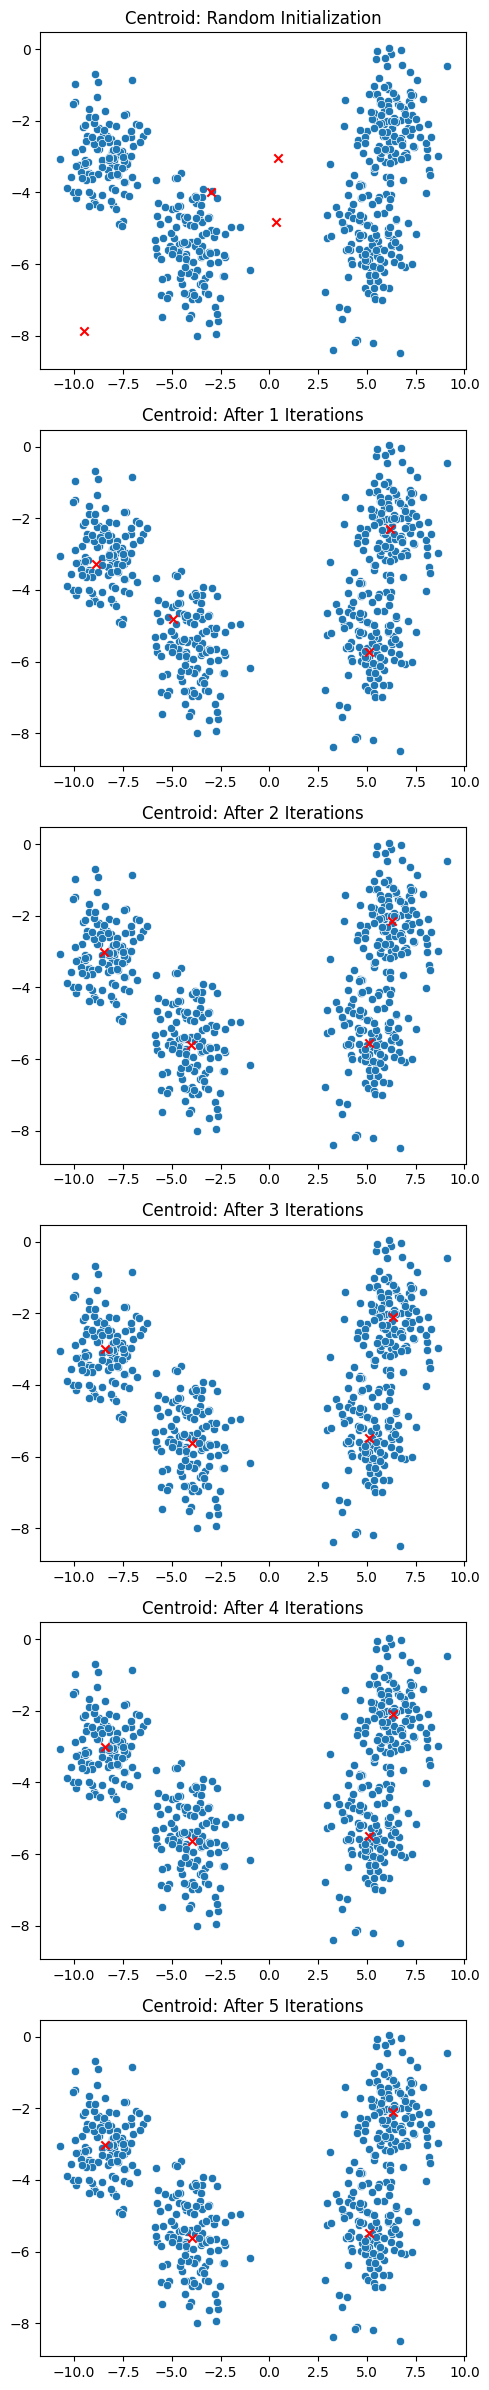

In [79]:
# plot the centroids per iteration
x_coords = [row[0] for row in X_2d]
y_coords = [row[1] for row in X_2d]

num_iterations = len(centroid_movement)

fig, ax = plt.subplots(num_iterations, figsize=(5,num_iterations * 4))

for index, centroid in enumerate(centroid_movement):
    title = "Centroid: Random Initialization" if index == 0 else f"Centroid: After {index} Iterations"
    plot_2d_results(x_coords, y_coords, centroid, title, ax[index])

plt.tight_layout()

## Comparison
Next lets compare our implementation on multi-dimensional data against the scikit-learn implementation. The scikit-learn implementation is much faster and more optimized since it uses numpy. It also uses an Expectation-Maximization algorithm instead of the basic mean distance implementation used by out model. We will initialize it with the same `1e-5` tolerance, and the random choice init method.

To score the models we will use the Davies Bouldin (lower is better) and Calinski Harabasz (higher is better) scores from the sklearn metrics module.

We will generate a dataset consisting of:
- 10000 data points
- 15 features
- 6 clusters

In [80]:
# create the larger data set for sklearn KMeans comparison
larger_example = make_blobs(n_samples=10000, n_features=15, centers=6)
larger_example_data = larger_example[0]

In [81]:
from sklearn.cluster import KMeans as sk_KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [82]:
# fit our custom k-means model and inspect the inertia value of the best run
custom_k_means_multi = KMeans(6)
custom_k_means_multi.fit(larger_example_data.tolist())
custom_k_means_labels = custom_k_means_multi.predict(larger_example_data.tolist())
print(f"Inertia of the best run: {custom_k_means_multi._inertia}")

Inertia of the best run: 149656.9557942678


In [83]:
# fit the scikit-learn KMeans model and inspect the inertia value of the 
# best run using the most similar parameters to our custom model
sklearn_k_means = sk_KMeans(6, init='random', tol=.00001)
sklearn_k_means.fit(larger_example_data)
sklearn_k_means_labels = sklearn_k_means.predict(larger_example_data)
print(f"Inertia of the best run: {sklearn_k_means.inertia_}")

Inertia of the best run: 149656.95579426878


In [84]:
# calculate the Davies Bouldin and Calinski Harabasz score both models
custom_davies_bouldin = davies_bouldin_score(larger_example_data, custom_k_means_labels)
custom_calinski_harabasz = calinski_harabasz_score(larger_example_data, custom_k_means_labels)

sklearn_davies_bouldin = davies_bouldin_score(larger_example_data, sklearn_k_means_labels)
sklearn_calinski_harabasz = calinski_harabasz_score(larger_example_data, sklearn_k_means_labels)

In [85]:
print("Davies Bouldin (lower is better)")
print(f"Custom model:       {custom_davies_bouldin}")
print(f"Scikit-learn model: {sklearn_davies_bouldin}")
print('\n')
print("Calinski Harabasz (higher is better)")
print(f"Custom model:       {custom_calinski_harabasz}")
print(f"Scikit-learn model: {sklearn_calinski_harabasz}")

Davies Bouldin (lower is better)
Custom model:       0.3377662314372269
Scikit-learn model: 0.3377662314372268


Calinski Harabasz (higher is better)
Custom model:       51265.19854498368
Scikit-learn model: 51265.19854498368


# Conclusion
This model although significantly slower (single threaded and written in pure python) it does seem to consistently converge. It also consistently returns the same Davies Bouldin and Calinski Harabasz scores as the scikit-learn implementation. It is important to note that using this random initialization requires multiple runs of the k-means algorithm to find the run with the lowest inertia or sum of squared distances between the centroids and their assigned points.

In [86]:
# documentation
from watermark import watermark
mark = watermark(author='Alexander Levin-Koopman', 
                 github_username='Alkoopman85', 
                 website='https://alkoopman85.github.io/')
print(mark)
print(watermark())
print('For the demonstration:')
print(watermark(packages='sklearn,seaborn,matplotlib'))

Author: Alexander Levin-Koopman

Github username: Alkoopman85

Website: https://alkoopman85.github.io/

Last updated: 2024-10-26T09:35:31.324106-07:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.28.0

Compiler    : GCC 14.2.1 20240910
OS          : Linux
Release     : 6.11.3-arch1-1
Machine     : x86_64
Processor   : 
CPU cores   : 12
Architecture: 64bit

For the demonstration:
sklearn   : 1.5.2
seaborn   : 0.13.2
matplotlib: 3.9.2



## References
scikit-learn. “Sklearn.cluster.KMeans — Scikit-Learn 0.21.3 Documentation.” Scikit-Learn.org, 
    2019, scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html.